In [1]:
!pip install -q transformers datasets tokenizers

     |████████████████████████████████| 3.1 MB 5.2 MB/s 
     |████████████████████████████████| 290 kB 47.5 MB/s 
     |████████████████████████████████| 3.3 MB 22.3 MB/s 
     |████████████████████████████████| 59 kB 6.8 MB/s 
     |████████████████████████████████| 895 kB 42.1 MB/s 
     |████████████████████████████████| 596 kB 47.0 MB/s 
     |████████████████████████████████| 243 kB 24.6 MB/s 
     |████████████████████████████████| 132 kB 49.8 MB/s 
     |████████████████████████████████| 1.1 MB 37.7 MB/s 
     |████████████████████████████████| 271 kB 49.2 MB/s 
     |████████████████████████████████| 192 kB 47.7 MB/s 
     |████████████████████████████████| 160 kB 46.3 MB/s 


# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config, optimization
from datasets import load_dataset
from tqdm.notebook import tqdm

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [4]:
emotion_dataset = load_dataset("emotion")

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотри, из чего состоит `emotion_dataset`:

In [ ]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [ ]:
emotion_dataset["train"]["label"][0]

0

In [ ]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [5]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [ ]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [ ]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [ ]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [6]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """

        text = self.dataset["train"]["text"][idx]
        label = self.dataset["train"]["label"][idx]
        
        tokenizer_output = tokenizer.encode_plus(
        text, 
        max_length=self.max_length, # максимальная длина текста
        padding="max_length", # надо ли добавлять паддинг в конце?
        return_tensors="pt", # возвращает pytorch тензоры
        )
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'].view(-1), 
            "mask": tokenizer_output['attention_mask'].view(-1),
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [7]:
train_dataset = TweetDataset("train")
valid_dataset = TweetDataset("validation") # validation
test_dataset = TweetDataset("test")

In [8]:
batch_size = 50 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [ ]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Подготовь оптимайзер и критерий:

In [ ]:
num_epochs = 10
num_batches = 320
lr = 1e-4 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = optimization.AdamW(model_0.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
scheduler = optimization.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_batches, num_training_steps=num_epochs*num_batches)

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [ ]:
batch = []
for b in train_loader:
  batch = b
  break

In [ ]:
tokens = batch['input_ids'].to(device) # Получи токены из датасета
mask = batch['mask'].to(device) # Получи маску из датасета

model_0(input_ids=tokens, attention_mask=mask)[0] # Посмотри на аутпут

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [ ]:
# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        predict = model_0(input_ids=batch['input_ids'].to(device), attention_mask=batch['mask'].to(device))[0]
        loss = criterion(predict, batch['target'].to(device))
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            predict = model_0(input_ids=batch['input_ids'].to(device), attention_mask=batch['mask'].to(device))[0]
            valid_loss += criterion(predict, batch['target'].to(device))
            valid_acc += (predict.argmax(-1) == batch['target'].to(device)).float().sum()
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / (len(valid_loader) * batch_size)}")
        
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        predict = model_0(input_ids=batch['input_ids'].to(device), attention_mask=batch['mask'].to(device))[0]
        test_acc += (predict.argmax(-1) == batch['target'].to(device)).float().sum()
print(f"Test Acc: {test_acc / (len(test_loader) * batch_size)}")

  0%|          | 0/320 [00:00<?, ?it/s]

Train Loss: 1.4860936403274536,Valid Loss: 0.8038013577461243,Valid Acc: 0.6960000395774841


  0%|          | 0/320 [00:00<?, ?it/s]

Train Loss: 0.42809638381004333,Valid Loss: 0.13075457513332367,Valid Acc: 0.9470000267028809


  0%|          | 0/320 [00:00<?, ?it/s]

Train Loss: 0.16214120388031006,Valid Loss: 0.0563620887696743,Valid Acc: 0.9790000319480896


  0%|          | 0/320 [00:00<?, ?it/s]

Train Loss: 0.09121358394622803,Valid Loss: 0.03842247277498245,Valid Acc: 0.9860000610351562


  0%|          | 0/320 [00:00<?, ?it/s]

Train Loss: 0.057819005101919174,Valid Loss: 0.01550121046602726,Valid Acc: 0.9945000410079956


  0%|          | 0/320 [00:00<?, ?it/s]

Train Loss: 0.03837020695209503,Valid Loss: 0.007338684983551502,Valid Acc: 0.9980000257492065


  0%|          | 0/320 [00:00<?, ?it/s]

Train Loss: 0.021411370486021042,Valid Loss: 0.004662772174924612,Valid Acc: 0.9980000257492065


  0%|          | 0/320 [00:00<?, ?it/s]

Train Loss: 0.012846064753830433,Valid Loss: 0.003940632566809654,Valid Acc: 0.9980000257492065


  0%|          | 0/320 [00:00<?, ?it/s]

Train Loss: 0.01028450671583414,Valid Loss: 0.00271015428006649,Valid Acc: 0.999000072479248


  0%|          | 0/320 [00:00<?, ?it/s]

Train Loss: 0.00842630211263895,Valid Loss: 0.0028127136174589396,Valid Acc: 0.999000072479248
Test Acc: 0.999000072479248


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [21]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [22]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
text = emotion_dataset["test"]['text'][1]
tokens = tokenizer.tokenize(text)

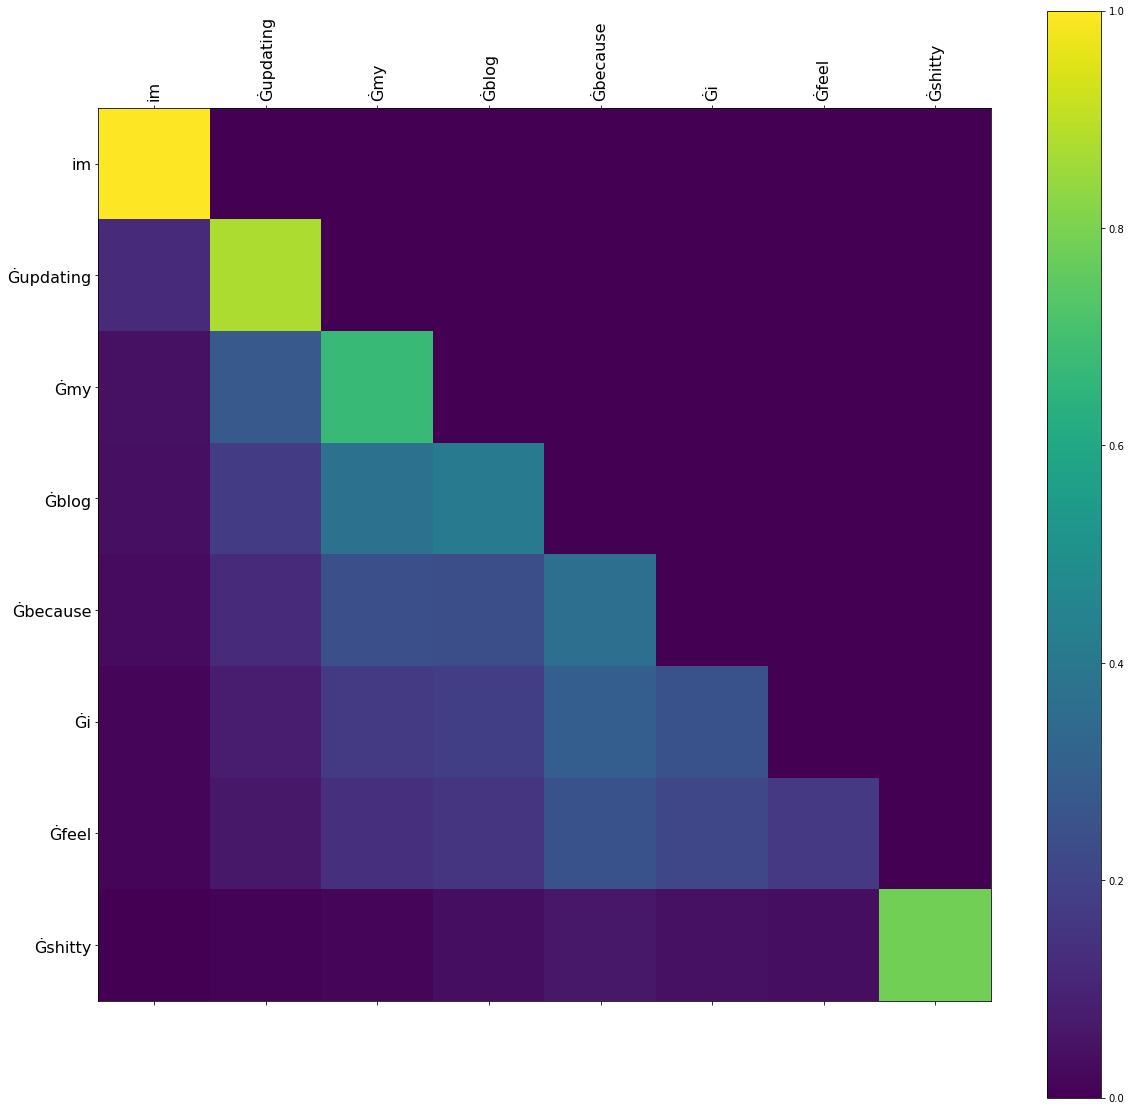

In [ ]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[3][-1])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [16]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
num_epochs = 8
num_batches = 320
lr = 1e-4 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = optimization.AdamW(model_1.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
scheduler = optimization.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_batches, num_training_steps=num_epochs*num_batches)

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [18]:
# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        predict = model_1(input_ids=batch['input_ids'].to(device), attention_mask=batch['mask'].to(device))[0]
        loss = criterion(predict, batch['target'].to(device))
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss
    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            predict = model_1(input_ids=batch['input_ids'].to(device), attention_mask=batch['mask'].to(device))[0]
            valid_loss += criterion(predict, batch['target'].to(device))
            valid_acc += (predict.argmax(-1) == batch['target'].to(device)).float().sum()
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / (len(valid_loader) * batch_size)}")
        
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        predict = model_1(input_ids=batch['input_ids'].to(device), attention_mask=batch['mask'].to(device))[0]
        test_acc += (predict.argmax(-1) == batch['target'].to(device)).float().sum()
print(f"Test Acc: {test_acc / (len(test_loader) * batch_size)}")

  0%|          | 0/320 [00:00<?, ?it/s]

Train Loss: 1.0609368085861206,Valid Loss: 0.1973547637462616,Valid Acc: 0.9310000538825989


  0%|          | 0/320 [00:00<?, ?it/s]

Train Loss: 0.18890641629695892,Valid Loss: 0.09231828153133392,Valid Acc: 0.9600000381469727


  0%|          | 0/320 [00:00<?, ?it/s]

Train Loss: 0.12126367539167404,Valid Loss: 0.0728844478726387,Valid Acc: 0.9585000276565552


  0%|          | 0/320 [00:00<?, ?it/s]

Train Loss: 0.09709612280130386,Valid Loss: 0.07117961347103119,Valid Acc: 0.955500066280365


  0%|          | 0/320 [00:00<?, ?it/s]

Train Loss: 0.0851128026843071,Valid Loss: 0.0551094114780426,Valid Acc: 0.971500039100647


  0%|          | 0/320 [00:00<?, ?it/s]

Train Loss: 0.06825710833072662,Valid Loss: 0.04943367466330528,Valid Acc: 0.9780000448226929


  0%|          | 0/320 [00:00<?, ?it/s]

Train Loss: 0.06153229624032974,Valid Loss: 0.044716592878103256,Valid Acc: 0.9800000190734863


  0%|          | 0/320 [00:00<?, ?it/s]

Train Loss: 0.05608793720602989,Valid Loss: 0.04258762672543526,Valid Acc: 0.9830000400543213
Test Acc: 0.9830000400543213


Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [32]:
text = emotion_dataset["test"]['text'][20]
tokens = tokenizer.tokenize(text)

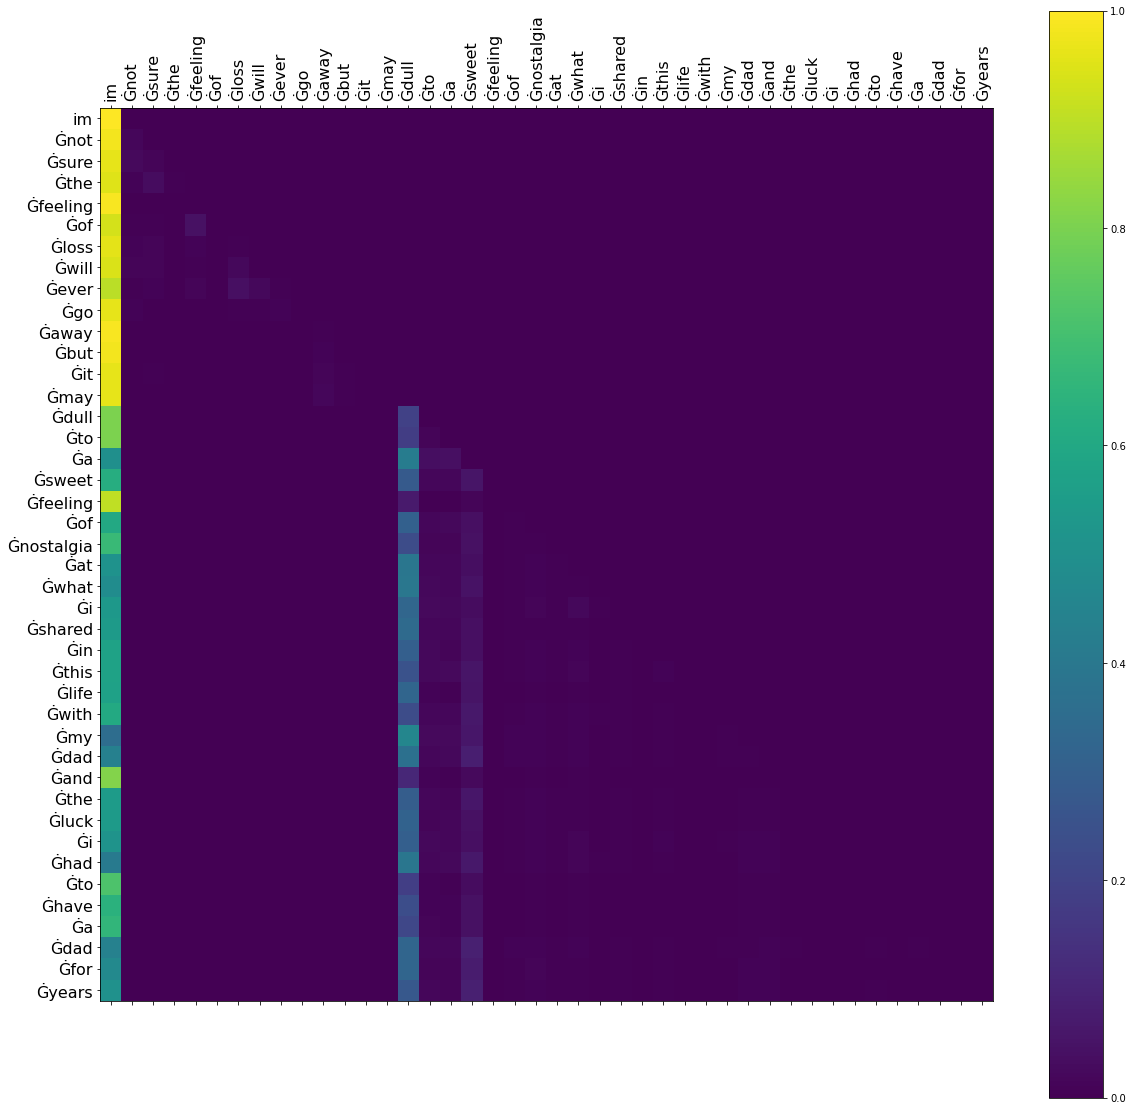

In [34]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[5][-1])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Есть ли прирост качества или скорости обучения при использовании предобученной модели?

К сожалению, нет. Предобученная модель уже после первой эпохи имеет 90+% accuracy. Но при этом она не достигает в конечном итоге значений, которых достигает первая модель. Единственное хочу отметить, что в силу того, что последний батч отличен от batch_size (50) а я считаю итоговый скор, предполагая, что все батчи имеют одинаковый размер, я получил accuracy = 0.999000072479248% для первой модели на тест-выборке. Можно утверждать, что это 100% accuracy
- Какой подход оказался лучше?

Интересно то, что первый подход оказался лучше. Несмотря на то, что вторая модель обучалась 8 эпох, а не 10, все равно заметно, что сходится она хуже, чем первая. 
- На какие слова модель большего всего обращала внимание?

Посмотрев большое колчество attention maps я заметил, что важными для первой модели становились прилагательные и глаголы. Реже некоторые существительные. Это естественно т.к. глаголы и прилагательные лучше отражают эмоции и оттенки речи. Для второй модели обычно на всех слоях и во всех головах внимание было на все слова для первого слова в предложении.
- На каких слоях/головах модель обращала внимание?

Тяжело сказать о головах. В зависимости от входного текста головы вели себя по-разному. Замечали разные связи, где-то некоторые из голов вообще не реагировали. А что касается слоев, то внимание становится более выраженным на последних слоях